## SCIP example

In [1]:
from optiwindnet.importer import load_repository
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.interarraylib import G_from_S
from optiwindnet.heuristics import EW_presolver
from optiwindnet.MILP import solver_factory, ModelOptions

### Initialize Sheringham Shoal

In [2]:
locations = load_repository()

In [3]:
L = locations.sheringham
capacity = 6

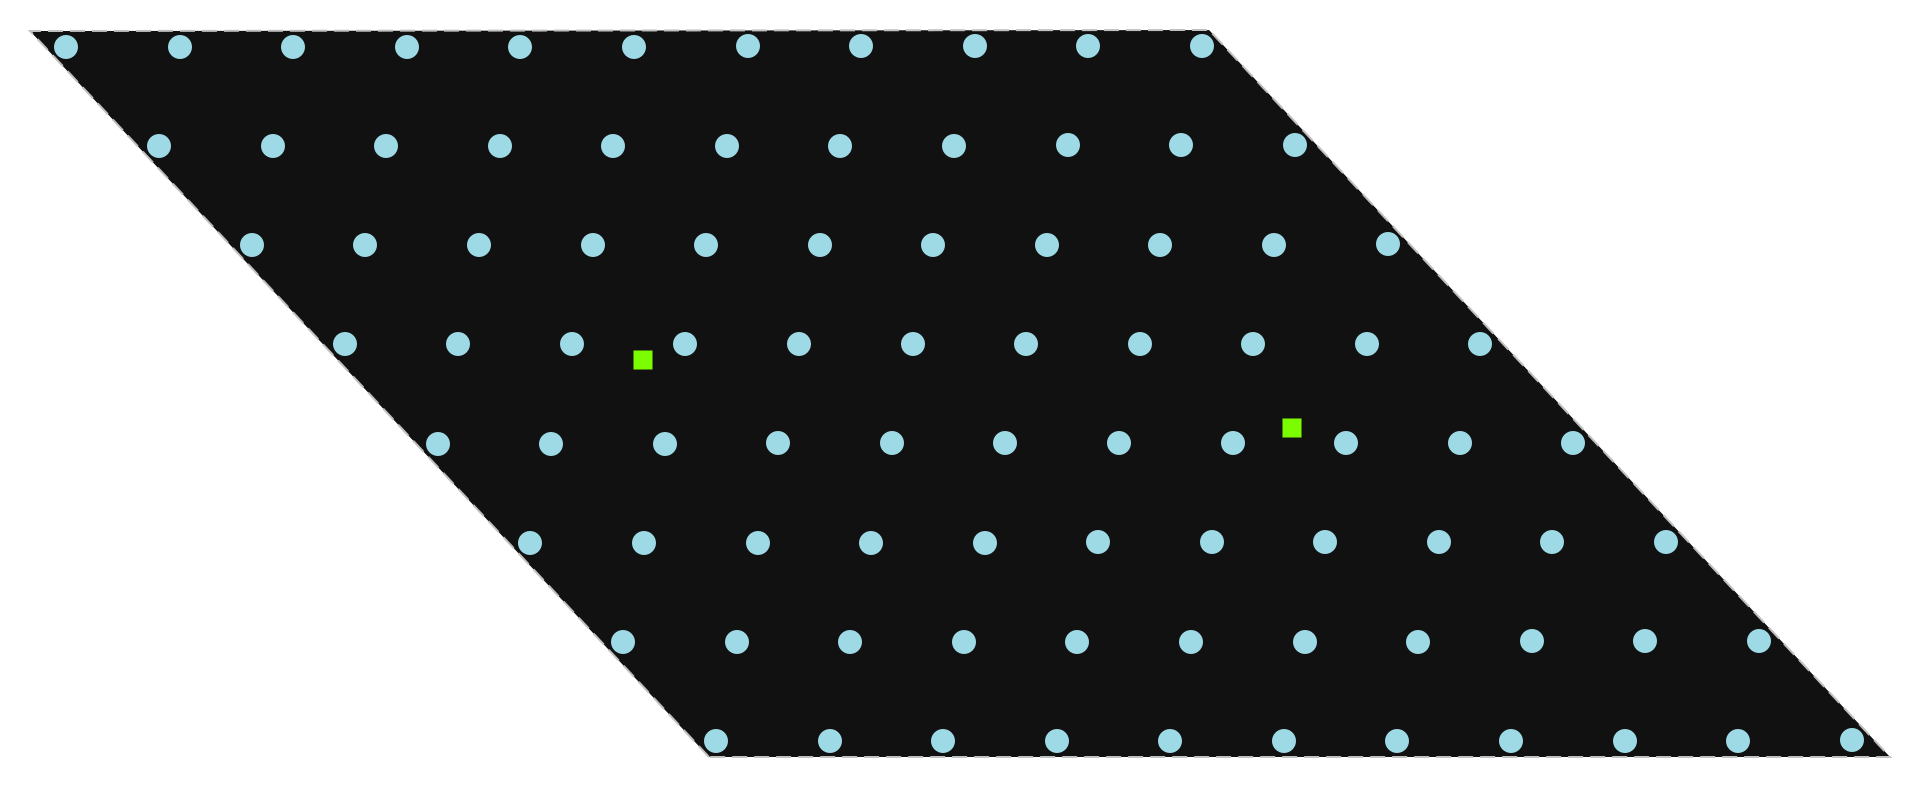

In [4]:
svgplot(L)

In [5]:
solver = solver_factory('scip')

### Optimize Sheringham Shoal

In [6]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

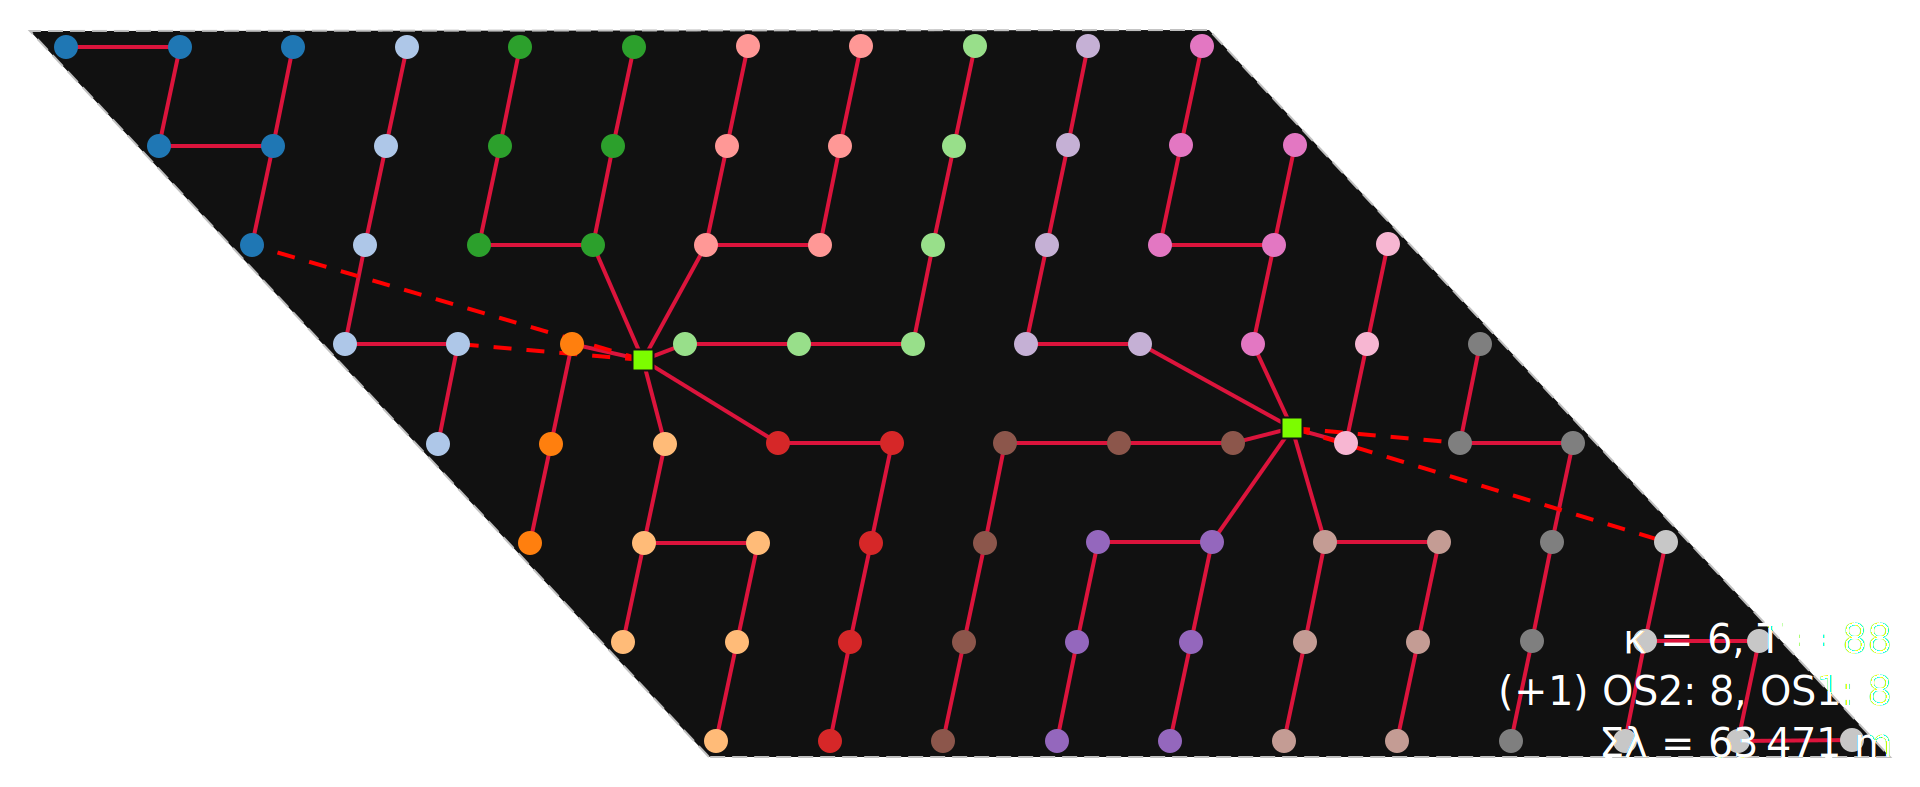

In [7]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [8]:
solver = solver_factory('scip')

If SCIP was compiled with multi-threading capability, multiple concurrent solver instances are started. OptiWindNet's default options prioritize launching feasibility-focused instances, but the choice of emphasis can be tuned by setting different weights.

The maximum number of concurrent threads can be set with option `'parallel/maxnthreads'`. SCIP's concurrent solver uses `min(8, cpu_count())` by default, but it may decide to use a lower number to limit RAM usage.

In [9]:
solver.options

{'concurrent/scip-feas/prefprio': 0.6,
 'concurrent/scip/prefprio': 0.3,
 'concurrent/scip-cpsolver/prefprio': 0,
 'concurrent/scip-easycip/prefprio': 0,
 'concurrent/scip-opti/prefprio': 0}

The latest [SCIP Optimization Suite precompiled packages](https://www.scipopt.org/index.php#download) include multi-threading, but the PySCIPOpt wheel must be built on top of the library distributed in that package ([see instructions](https://pyscipopt.readthedocs.io/en/latest/build.html)). Latest versions at the time of writting: SCIP 10.0.0, PySCIPOpt 6.0. The conda-forge `pyscipopt` was at version 5.6.0 and was not concurrecy-enabled for all platforms at the time ([check latest version](https://anaconda.org/channels/conda-forge/packages/pyscipopt/overview)).

In [10]:
solver.set_problem(
    P, A,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="unlimited",
    ),
    warmstart=Sʹ,
)

In [11]:
solver.solve(
    mip_gap=0.005,
    time_limit=60,
)

SolutionInfo(runtime=60.0, bound=60371.990294157695, objective=61606.94944045488, relgap=0.020045776613088373, termination='timelimit')

> Note: If SCIP lacks multi-threading capability, a warning will be displayed and it will fall back to the single-threaded solver. The warning about the lack of concurrent capability looks like this:
```
.../optiwindnet/MILP/scip.py:96: UserWarning: SCIP was compiled without task processing interface. Parallel solve not possible - using optimize() instead of solveConcurrent()
  model.solveConcurrent()
```

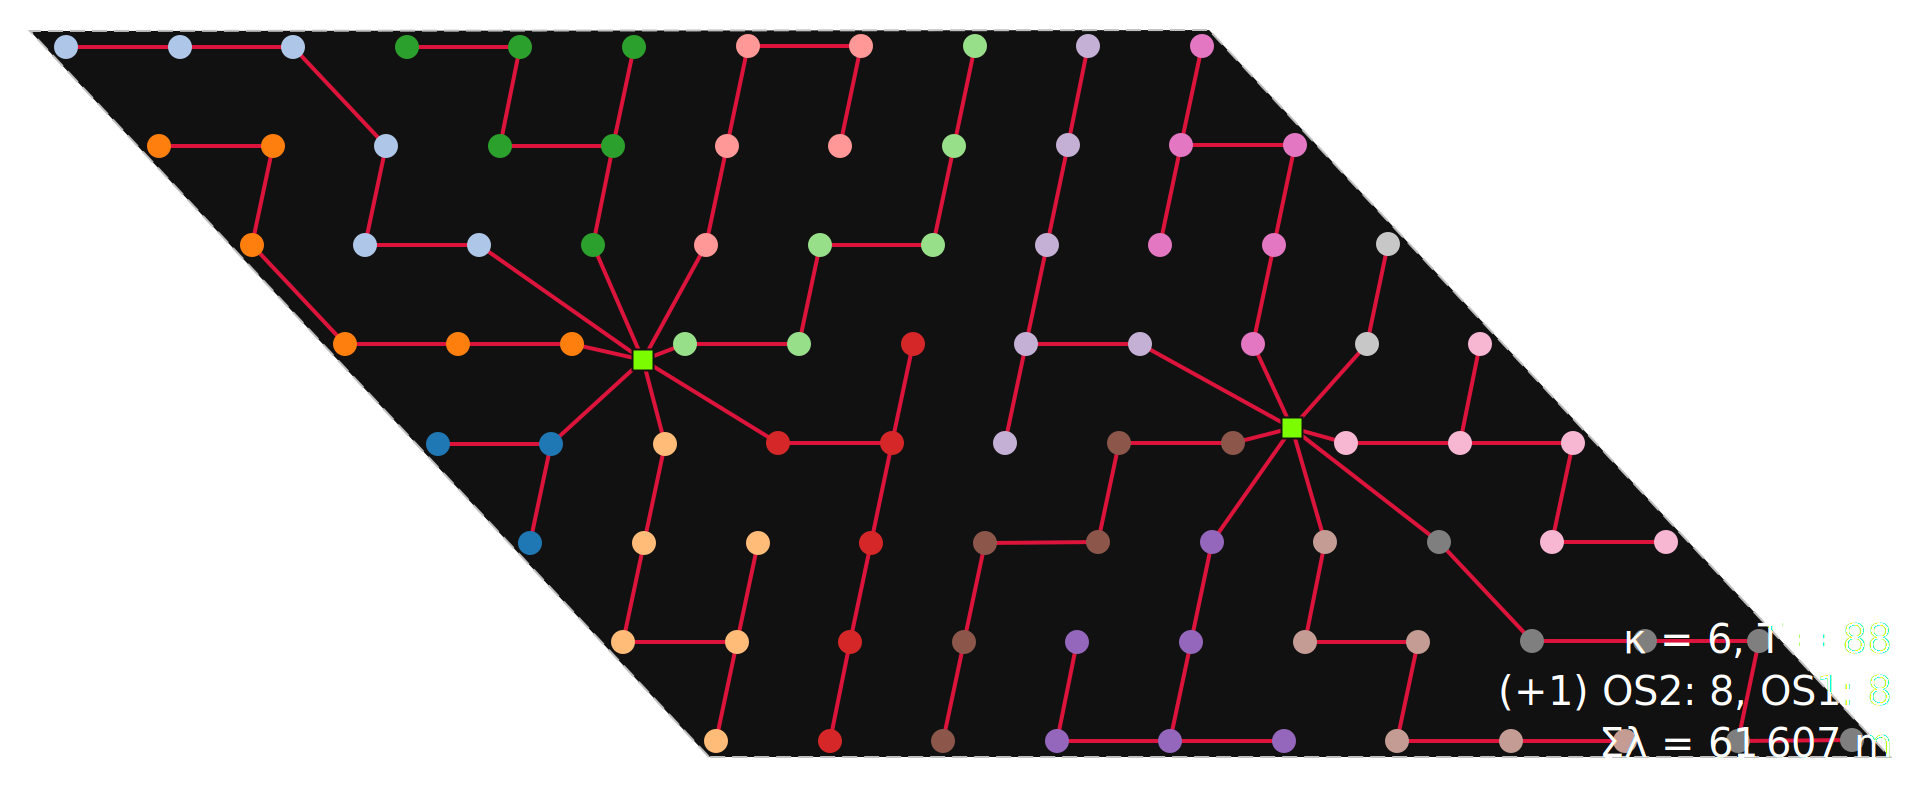

In [12]:
S, G = solver.get_solution()
svgplot(G)